# 00. 개발 환경 설정

## 00-0. 필요 라이브러리 설치

In [1]:
!pip3 install pandas matplotlib scikit-learn

## 00-1. 라이브러리 import

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter

## 00-3. 학습 디바이스 정의

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Now using {device}.")

Now using cuda.


# 01. 학습 준비

## 01-1. 데이터셋 로드

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 본인 환경에 맞게 조정
file_path = '/content/drive/MyDrive/실습/IMDB.csv'

df = pd.read_csv(file_path)

print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## 01-02. 데이터셋 전처리

In [6]:
def text_cleaning(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return ' '.join(text)

df['review'] = df['review'].apply(text_cleaning)

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

text = df['review'].tolist()
label = df['sentiment'].tolist()

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=42, shuffle=True)

def build_vocab(data, min_freq=5):
    counter = Counter()

    for review in data:
        words = review.split()
        counter.update(words)

    vocab = {'<unk>': 0}
    index = 1

    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = index
            index += 1

    return vocab

vocab = build_vocab(x_train)

print(f"Vocabulary Size: {len(vocab)}")

Vocabulary Size: 35706


In [7]:
def get_avg_length(text_list):
    avg_length = 0
    for sentence in text_list:
        tokens = sentence.split()
        avg_length += len(tokens)

    avg_length /= len(text_list)
    return int(avg_length)

def pad_sequence(seq, max_length, pad_value=0):
    if len(seq) < max_length:
        return seq + [pad_value] * (max_length - len(seq))
    else:
        return seq[:max_length]

def text_encoding(text_list, vocab, max_length):
    encoded_padded_sequences = []

    for sentence in text_list:
        encoded_sentence = [vocab.get(word, vocab['<unk>']) for word in sentence.split()]
        padded_sentence = pad_sequence(encoded_sentence, max_length)
        encoded_padded_sequences.append(padded_sentence)

    return encoded_padded_sequences

x_train = text_encoding(x_train, vocab, max_length=get_avg_length(x_train))
x_test = text_encoding(x_test, vocab, max_length=get_avg_length(x_test))

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, text_encoded, label):
        self.text_encoded = text_encoded
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        review = self.text_encoded[idx]  # 리뷰 텍스트
        label = self.label[idx]   # 감정 라벨
        return review, label

train_dataset = IMDBDataset(torch.tensor(x_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = IMDBDataset(torch.tensor(x_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# 02. 모델 준비

## 02-01. RNN

In [9]:
import torch.nn as nn
import torch

class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, padding_idx=0):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.padding_idx = padding_idx

    def forward(self, text):
        lengths = (text != self.padding_idx).sum(dim=1)
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, hidden = self.rnn(packed_embedded)  # RNN에서는 hidden만 반환

        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        batch_size = text.size(0)
        idx = torch.arange(batch_size)
        last_outputs = output[idx, lengths - 1, :]

        output = self.fc(last_outputs)
        return output

In [15]:
vocab_size = len(vocab)
embed_size = 32
hidden_size = 16
output_size = 1

model = RNNModel(vocab_size, embed_size, hidden_size, output_size).to(device)

model

RNNModel(
  (embedding): Embedding(35706, 32, padding_idx=0)
  (rnn): RNN(32, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

# 03. 모델 학습

In [17]:
epochs = 5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    correct = 0

    for batch in data_loader:
        text, label = batch
        text = text.to(device)
        label = label.to(device)
        label = label.unsqueeze(1).float()
        optimizer.zero_grad()
        output = model(text)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in data_loader:
            text, label = batch
            text = text.to(device)
            label = label.to(device)
            label = label.unsqueeze(1).float()
            output = model(text)
            loss = loss_fn(output, label)
            total_loss += loss.item()
            predictions = torch.round(torch.sigmoid(output))
            correct += (predictions == label).float().sum()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)

train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.detach().cpu())

Epoch 1, Train Loss: 0.692, Validation Loss: 0.690, Validation Accuracy: 53.18%
Epoch 2, Train Loss: 0.688, Validation Loss: 0.688, Validation Accuracy: 53.77%
Epoch 3, Train Loss: 0.686, Validation Loss: 0.686, Validation Accuracy: 54.62%
Epoch 4, Train Loss: 0.681, Validation Loss: 0.682, Validation Accuracy: 55.85%
Epoch 5, Train Loss: 0.675, Validation Loss: 0.675, Validation Accuracy: 57.71%


# 05. 결과 시각화

## 05-01. 학습 결과

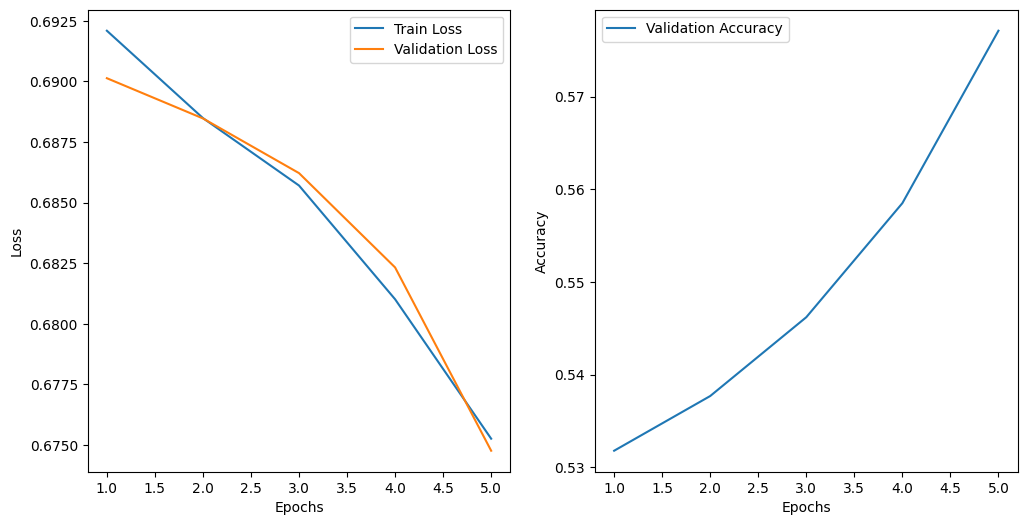

In [18]:
# 손실 및 정확도 시각화
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
